<a href="https://colab.research.google.com/github/liveness-detection-bangkit-team/liveness_ai/blob/main/spoof_mobilenetv3small_ariel6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install ai-edge-litert
#!pip install tflite-support-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
import seaborn as sns
import os
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#from ai_edge_litert.interpreter import Interpreter
#from tflite_support.metadata_writers import image_classifier
#from tflite_support.metadata_writers import writer_utils
print(tf.__version__)

2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke direktori dataset
train_dir = '/content/drive/MyDrive/datasets/datasets/train_spoof'
test_dir = '/content/drive/MyDrive/datasets/datasets/test_spoof'
MODEL_PATH = "/content/drive/MyDrive/Model_ariel"

In [ ]:
seed_init = 42
IMAGE_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= train_dir,
    image_size= IMAGE_SIZE,
    shuffle = True,
    #batch_size = None,
    subset = 'training',
    validation_split = 0.2,
    label_mode= 'binary',
)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= train_dir,
    image_size= IMAGE_SIZE,
    shuffle = True,
    #batch_size = None,
    subset= 'validation',
    validation_split = 0.2,
		label_mode= 'binary',
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= test_dir,
    #batch_size= None,
    image_size= IMAGE_SIZE,
    label_mode= 'binary',
)

Found 5958 files belonging to 2 classes.
Using 4767 files for training.
Found 5958 files belonging to 2 classes.
Using 1191 files for validation.
Found 100 files belonging to 2 classes.


Class names: ['fake', 'real']


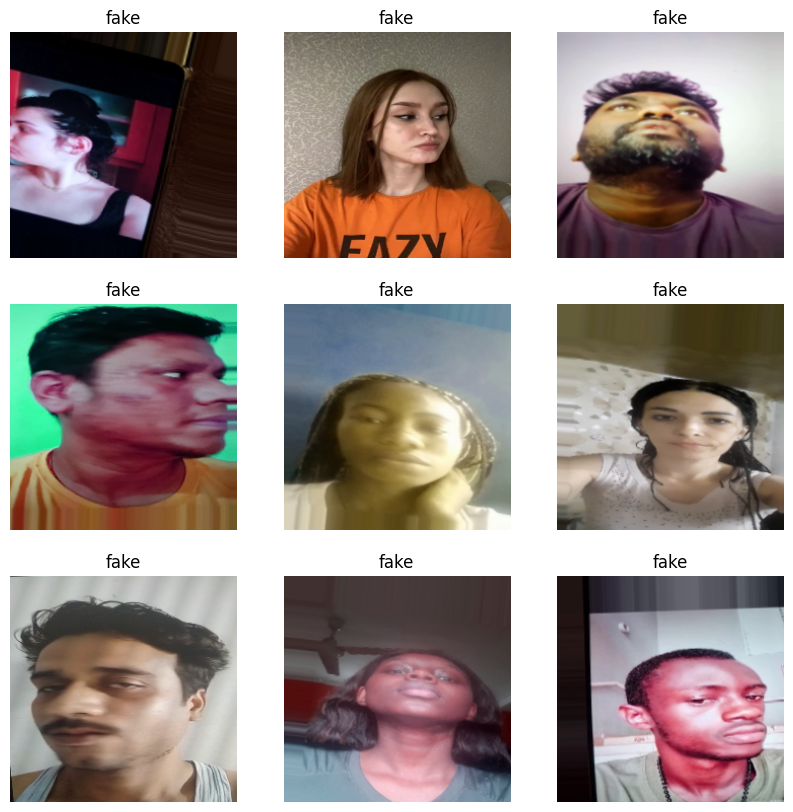

In [ ]:
train_class_names = train_dataset.class_names
print("Class names:", train_class_names)
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(train_class_names[label_index])
        plt.axis("off")
    plt.show()

Class names: ['fake', 'real']


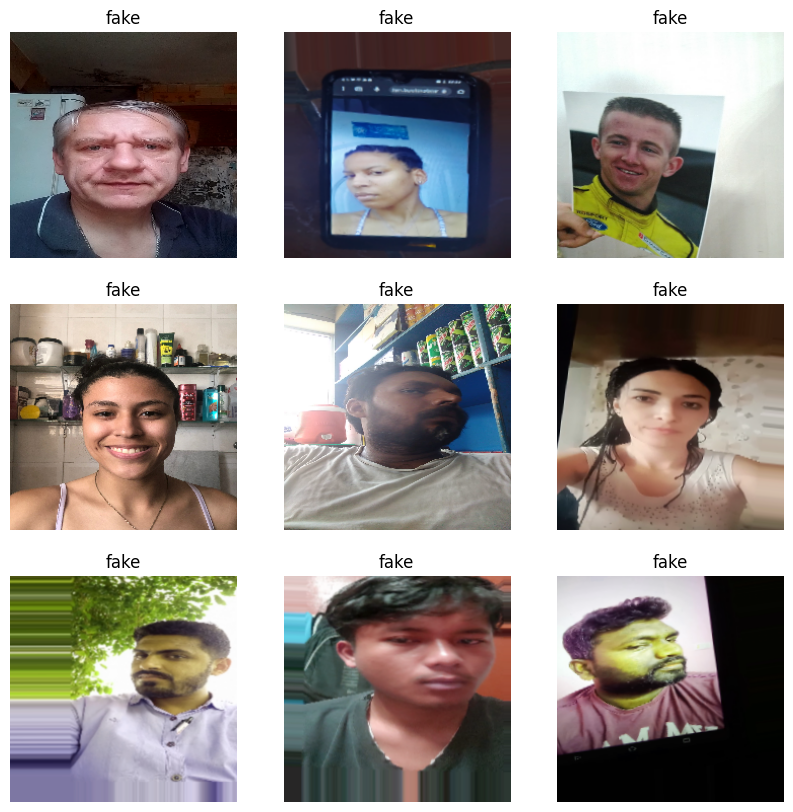

In [ ]:
validation_class_names = validation_dataset.class_names  # Get class names
print("Class names:", validation_class_names)

for images, labels in validation_dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to uint8 image
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value in the one-hot array
        plt.title(validation_class_names[label_index])  # Get class name using the index
        plt.axis("off")
    plt.show()

Class names: ['fake', 'real']


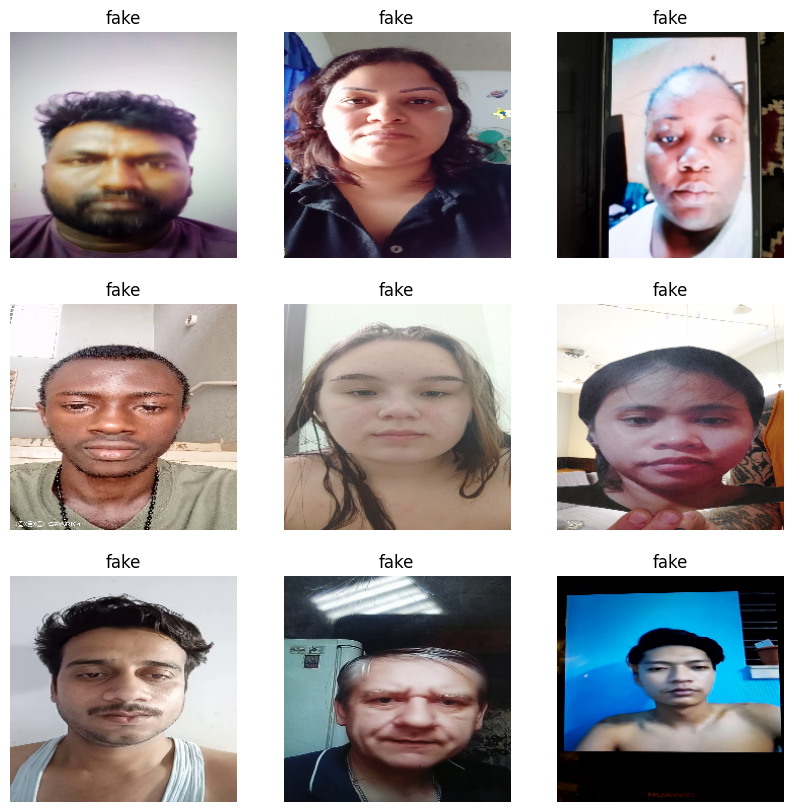

In [ ]:
test_class_names = test_dataset.class_names  # Get class names
print("Class names:", test_class_names)

for images, labels in test_dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to uint8 image
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value in the one-hot array
        plt.title(test_class_names[label_index])  # Get class name using the index
        plt.axis("off")
    plt.show()

[2979, 2979]


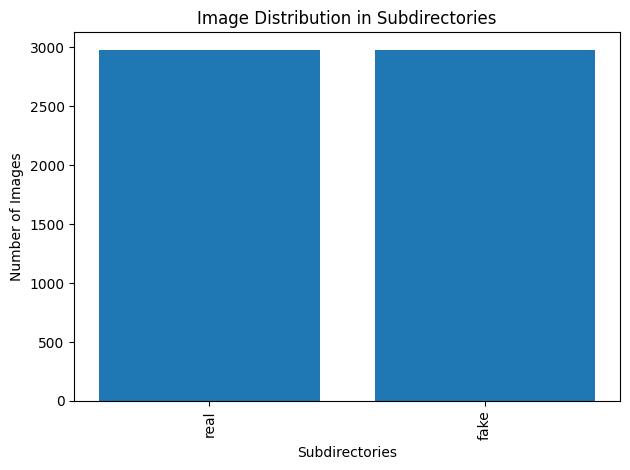

In [ ]:
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

counts = [len(os.listdir(directory)) for directory in subdirectories]

labels = [os.path.basename(directory) for directory in subdirectories]

print(counts)
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.xlabel("Subdirectories")
plt.title("Image Distribution in Subdirectories")
plt.tight_layout()
plt.show()

[50, 50]


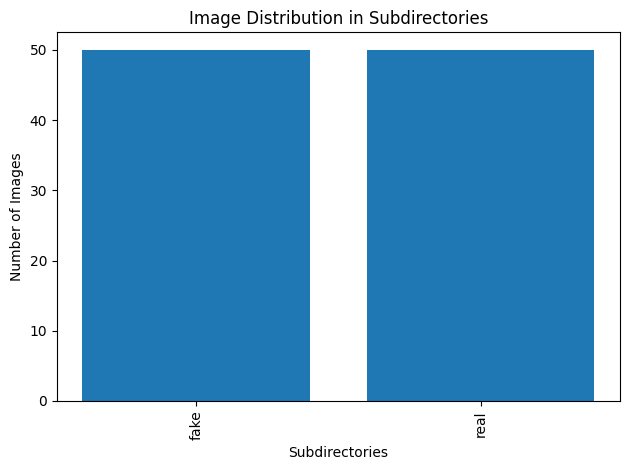

In [ ]:
subdirectories = [os.path.join(test_dir, d) for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]


counts = [len(os.listdir(directory)) for directory in subdirectories]

labels = [os.path.basename(directory) for directory in subdirectories]

print(counts)

plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.xlabel("Subdirectories")
plt.title("Image Distribution in Subdirectories")
plt.tight_layout()
plt.show()

In [ ]:
# data normalization
"""
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
])
"""

In [ ]:
# data augmentation
"""
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness([-0.8,0]),
  tf.keras.layers.RandomContrast(0.2)
])
"""

'\ndata_augmentation = tf.keras.Sequential([\n  tf.keras.layers.RandomBrightness([-0.8,0]),\n  tf.keras.layers.RandomContrast(0.2)\n])\n'

In [ ]:
# augmenting
# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# optimmize
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalizing on dataset
"""
train_dataset = train_dataset.map(lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y))
"""

In [ ]:
# optimize
"""
batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
"""

In [ ]:
IMAGE_SHAPE = (224, 224, 3)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
base_model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
#base_model.trainable = False
inputs = base_model.input
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
# x = data_augmentation(inputs)
#x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
print("trainable: ", base_model.trainable)

trainable:  True


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
                  learning_rate=0.001,
                  beta_1 = 0.9,
                  beta_2 = 0.999,
                  weight_decay = 0.0
                ),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,235,057 (4.71 MB)

 Trainable params: 1,222,945 (4.67 MB)

 Non-trainable params: 12,112 (47.31 KB)

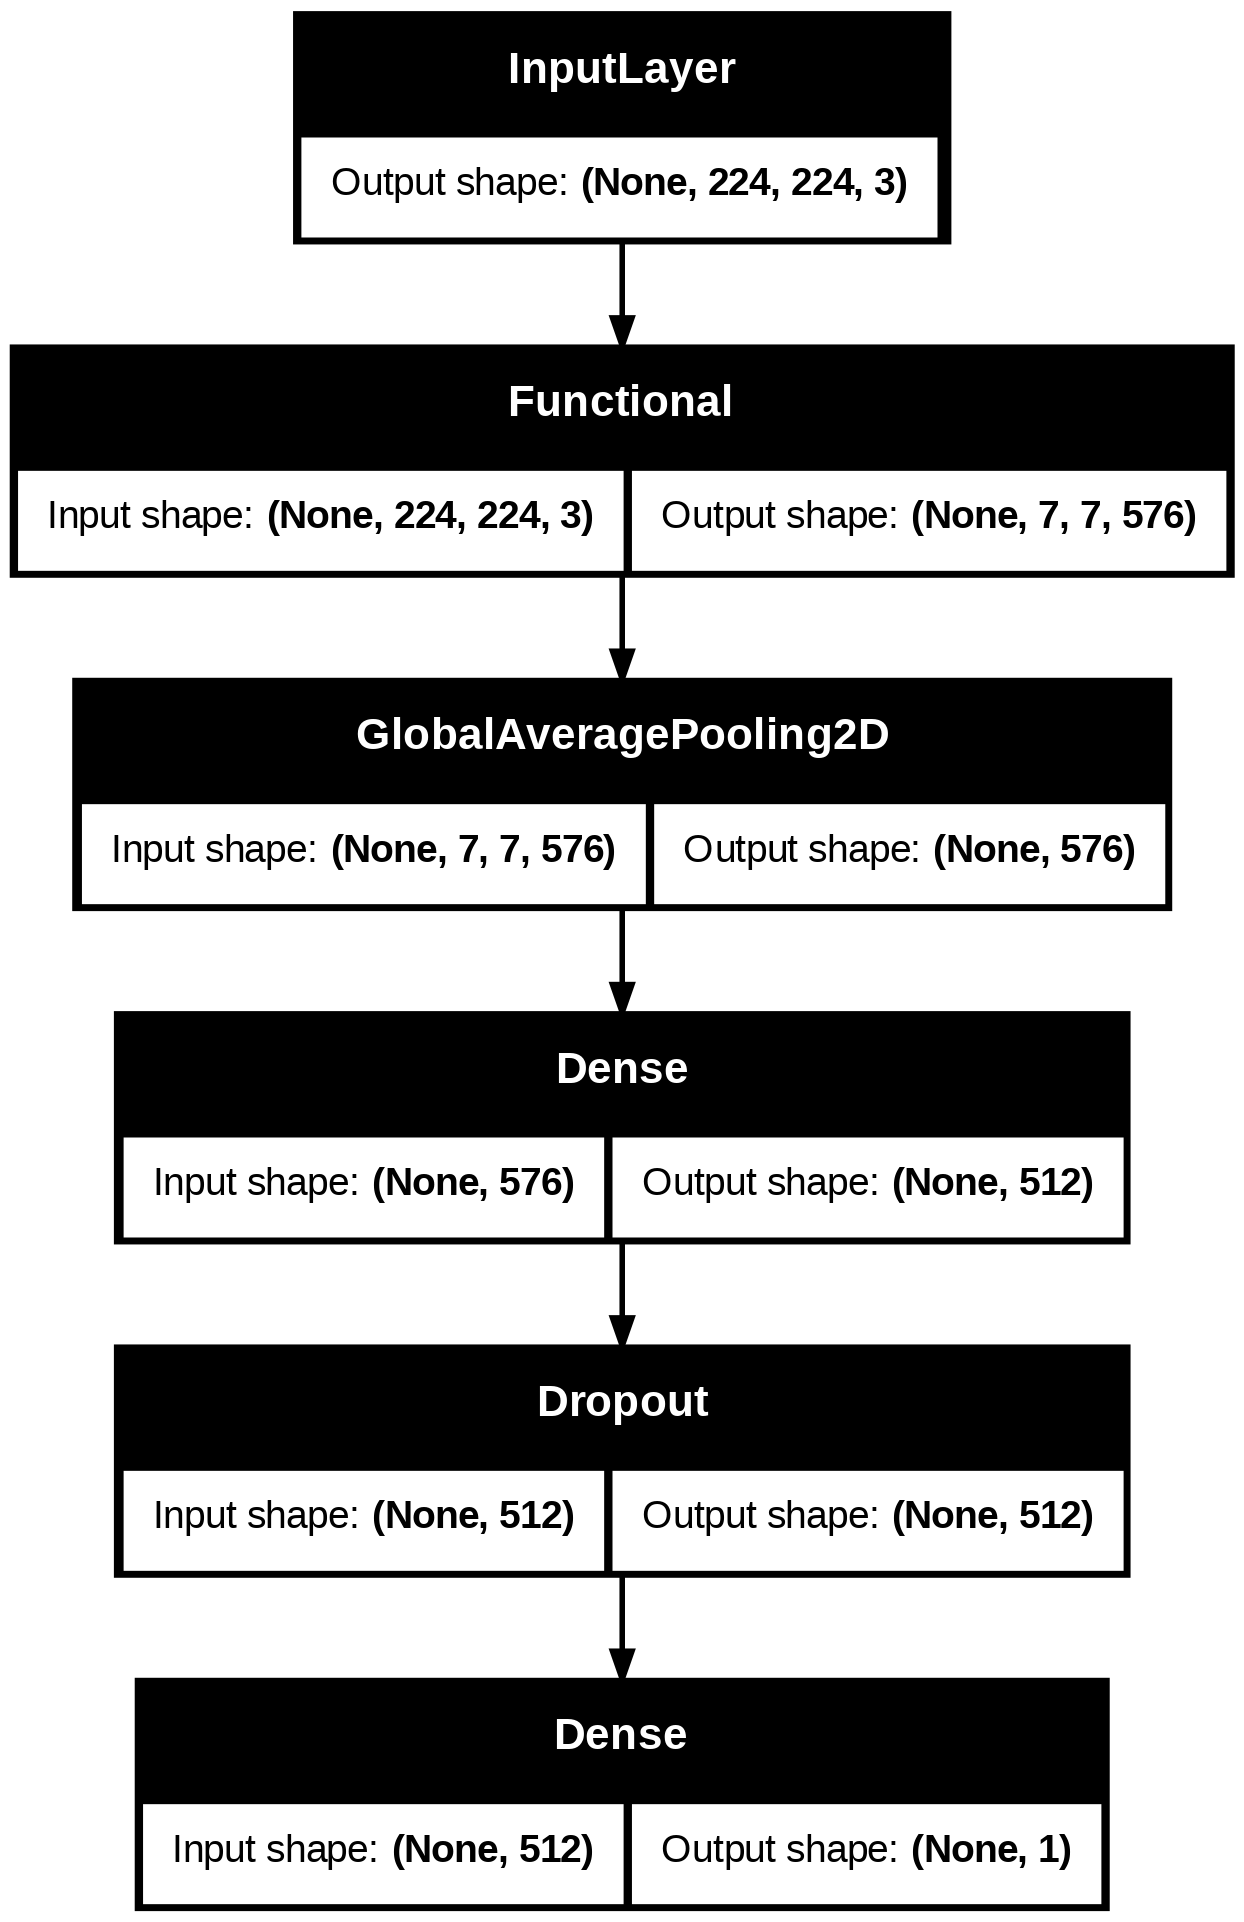

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
ReduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODEL_PATH, "spoof_mobilenetv3s_finetuned_checkpoint_ariel8.keras"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    )

history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[ReduceOnPlateau, early_stopping, checkpoint])

# Save model
model.save(os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_ariel8.keras'))

# Mengonversi model ke TFLite
loaded_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_ariel8.keras'))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_ariel8.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8765 - loss: 0.2618 - precision: 0.8728 - recall: 0.8748
Epoch 1: val_accuracy improved from -inf to 0.66919, saving model to /content/drive/MyDrive/Model_ariel/spoof_mobilenetv3s_finetuned_checkpoint_ariel8.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 847s 5s/step - accuracy: 0.8769 - loss: 0.2612 - precision: 0.8732 - recall: 0.8752 - val_accuracy: 0.6692 - val_loss: 2.5519 - val_precision: 0.9664 - val_recall: 0.3734 - learning_rate: 0.0010
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9846 - loss: 0.0437 - precision: 0.9826 - recall: 0.9859
Epoch 2: val_accuracy did not improve from 0.66919
149/149 ━━━━━━━━━━━━━━━━━━━━ 97s 399ms/step - accuracy: 0.9846 - loss: 0.0437 - precision: 0.9826 - recall: 0.9859 - val_accuracy: 0.6608 - val_loss: 6.3799 - val_precision: 0.9953 - val_recall: 0.3458 - learning_rate: 0.0010
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9902 - loss: 0.0258 - preci

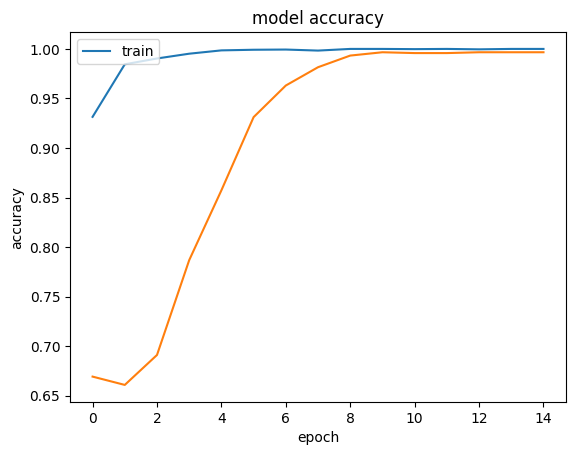

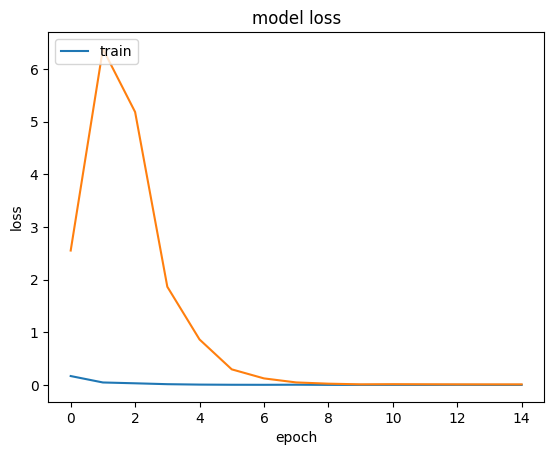

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.show()

plot_loss_acc(history)

In [ ]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.82031
Test Accuracy: 95.00%


In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
checkpoint_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_checkpoint_ariel8.keras'))

In [ ]:
checkpoint_results = checkpoint_model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(checkpoint_results[0]))
print("Test Accuracy: {:.2f}%".format(checkpoint_results[1] * 100))

    Test Loss: 0.82031
Test Accuracy: 95.00%


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_dataset)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (test_class_names)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 855ms/step


AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=10, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
"""
from google.colab import files
files.download('/content/allpos_mobilenetv3l_checkpoint_ariel4.keras')
"""

In [ ]:
# Quantize Save model
#model.save(os.path.join(MODEL_PATH, "allpos_mobilenetv3l_finetuned_ariel8.keras"))

# Mengonversi model ke TFLite
loaded_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_checkpoint_ariel8.keras'))
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_fp16_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = os.path.join(MODEL_PATH, 'spoof_mobilenetv3s_finetuned_fp16quantize_ariel8.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_fp16_model)

Saved artifact at '/tmp/tmplqet5sid'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140315838800544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838827504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838829616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838806352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838825216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838836304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838836480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838837008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838838064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838838768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315838943072

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(os.path.join(MODEL_PATH, 'Model_ariel_planB/spoof_mobilenetv2_fp16_planB_ariel1.tflite')))
interpreter.allocate_tensors()

In [ ]:
def evaluate_model(interpreter, dataset):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Initialize lists to store predictions and ground truth labels
  prediction_digits = []
  test_labels = []

  # Iterate over the test dataset
  for image_batch, labels_batch in dataset:
    # Iterate over each image and label in the batch
    for test_image, label in zip(image_batch.numpy(), labels_batch.numpy()):
      # Pre-processing: add batch dimension and convert to float32
      test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
      interpreter.set_tensor(input_index, test_image)

      # Run inference
      interpreter.invoke()

      # Post-processing: remove batch dimension and find the digit with highest probability
      output = interpreter.tensor(output_index)
      digit = np.argmax(output()[0])
      prediction_digits.append(digit)
      test_labels.append(np.argmax(label)) # Store the true label

  # Compare prediction results with ground truth labels to calculate accuracy
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
print(evaluate_model(interpreter, test_dataset))

1.0


## TFLite metadata

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow=="2.13.0"

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing

In [ ]:
!pip install tflite-support-nightly

In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [ ]:
_MODEL_PATH = os.path.join(MODEL_PATH, "spoof_mobilenetv3s_finetuned_fp16quantize_255metadata_ariel8.tflite")
_LABEL_FILE = os.path.join(MODEL_PATH, "spoof_labels.txt")
_SAVE_TO_PATH = os.path.join(MODEL_PATH, "spoof_mobilenetv3s_finetuned_fp16quantize_255metadata_ariel8.tflite")

### Metadata writer codegen

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

### Metadata flatbuffer

In [ ]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV3 image classifier"
model_meta.description = ("Identify the most prominent face direction in the "
                          "image from a set of 2, real or fake.")
model_meta.version = "v8"
model_meta.author = "Ariel"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 2 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(_LABEL_FILE)
label_file.description = "Labels for spoof directions that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file(_MODEL_PATH)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([_LABEL_FILE])
populator.populate()

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

In [ ]:
model_buffer = writer_utils.load_file(_MODEL_PATH)

# Create general model information.
general_md = metadata_info.GeneralMd(
    name="ImageClassifier_FaceDirection",
    version="v4",
    description=("Identify the face Direction in the image from a "
                 "known set of categories."),
    author="Ariel",
    licenses="Apache License. Version 2.0")

# Create input tensor information.
input_md = metadata_info.InputImageTensorMd(
    name="input image",
    description=("Input image to be classified. The expected image is "
                 "224 x 224, with three channels (red, blue, and green) per "
                 "pixel. Each element in the tensor is a value between min and "
                 "max, where (per-channel) min is [-1] and max is [1]."),
    norm_mean=[127.5],
    norm_std=[127.5],
    color_space_type=_metadata_fb.ColorSpaceType.RGB,
    tensor_type=writer_utils.get_input_tensor_types(model_buffer)[0])

# Create output tensor information.
output_md = metadata_info.ClassificationTensorMd(
    name="probability",
    description="Probabilities of the 5 labels respectively.",
    label_files=[
        metadata_info.LabelFileMd(file_path=_LABEL_FILE,
                                  locale="en")
    ],
    tensor_type=writer_utils.get_output_tensor_types(model_buffer)[0])

NameError: name 'metadata_info' is not defined

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
# Create the metadata writer.
writer = ImageClassifierWriter.create_from_metadata_info(
    model_buffer, general_md, input_md, output_md)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier_FaceDirection",
  "description": "Identify the face Direction in the image from a known set of categories.",
  "version": "v4",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "input image",
          "description": "Input image to be classified. The expected image is 224 x 224, with three channels (red, blue, and green) per pixel. Each element in the tensor is a value between min and max, where (per-channel) min is [-1] and max is [1].",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
  

ValueError: File, 'allpos_labels.txt', has already been packed.

In [ ]:
Interpreter = Interpreter(model_path='/content/drive/MyDrive/Model_ariel/alpos_mobilenetv3s_ariel5.tflite')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Model_ariel/allpos_mobilenetv3s_checkpoint_ariel5.keras')
loaded_model.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 955ms/step - accuracy: 0.9909 - loss: 0.1122 - precision: 0.9909 - recall: 0.9909


[0.1343877911567688,
 0.9900000095367432,
 0.9900000095367432,
 0.9900000095367432]

## Benchmark

In [ ]:
!adb install -r -d -g android_aarch64_benchmark_model.apk


/bin/bash: line 1: adb: command not found


In [ ]:
!adb push your_model.tflite /data/local/tmp